In [1]:
import os
import xarray as xr
import random 
import numpy as np
from sklearn.metrics import mean_squared_error


# pytorch
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Eurac utils
from hython.hython.datasets.dataset_reader import xarray_to_array, create_dataset
from hython.hython.models.lstm import CustomLSTMModel
from hython.hython.train_val import train_val

import warnings
warnings.filterwarnings("ignore")

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

In [3]:
import glob 
glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')

['/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data']

In [4]:
dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all')#.to_dataset(dim='variable')
static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all')#.to_dataset(dim='variable')
target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all')

In [5]:
dyn_vars_ds

<xarray.Dataset>
Dimensions:      (time: 5844, lat: 214, lon: 245)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2015-12-31
  * lat          (lat) float64 47.09 47.08 47.07 47.06 ... 45.33 45.32 45.31
  * lon          (lon) float64 10.29 10.3 10.3 10.31 ... 12.3 12.3 12.31 12.32
Data variables:
    precip       (time, lat, lon) float32 ...
    pet          (time, lat, lon) float32 ...
    temp         (time, lat, lon) float32 ...
    spatial_ref  (time) int32 ...
Attributes:
    units:           mm d**-1
    long_name:       Total precipitation
    category:        meteo
    notes:           Extracted from Copernicus Climate Data Store; resampled ...
    paper_doi:       10.1002/qj.3803
    paper_ref:       Hersbach et al. (2019)
    source_license:  https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...
    source_url:      https://doi.org/10.24381/cds.bd0915c6
    source_version:  ERA5 daily data on pressure levels
    _FillValue:      nan
    unit:            mm
    precip_fn:       era5

In [6]:
static_params_ds

<xarray.Dataset>
Dimensions:               (lat: 214, lon: 245, time: 12, layer: 4)
Coordinates:
  * lat                   (lat) float64 47.09 47.08 47.07 ... 45.33 45.32 45.31
  * lon                   (lon) float64 10.29 10.3 10.3 ... 12.3 12.31 12.32
  * time                  (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * layer                 (layer) int64 0 1 2 3
    spatial_ref           int32 ...
Data variables: (12/76)
    x_out                 (lat, lon) float64 ...
    y_out                 (lat, lon) float64 ...
    idx_out               (lat, lon) float64 ...
    wflow_ldd             (lat, lon) float32 ...
    wflow_subcatch        (lat, lon) float64 ...
    wflow_uparea          (lat, lon) float32 ...
    ...                    ...
    TTM                   (lat, lon) float32 ...
    WHC                   (lat, lon) float32 ...
    G_Cfmax               (lat, lon) float32 ...
    G_SIfrac              (lat, lon) float32 ...
    G_TT                  (lat, lon) float32 ...
    wflow_gauges_eurac    (lat, lon) float64 ...

In [7]:
stat_parmas = ['dem_subgrid','KsatVer_100.0cm', 'wflow_dem','hydrodem_avg_D8', 'N',
               'RootingDepth', 'thetaS','thetaR','KsatVer', 'M_original_', 'f_', 'M_original', 'f']

stat_parmas = ['KsatVer_0.0cm', 'wflow_dem']

dyn_vars_ds1 = dyn_vars_ds.sel(time=slice(dyn_vars_ds.time[0], dyn_vars_ds.time[1094]))
target_ds1 = target_ds.sel(time=slice(target_ds.time[0], target_ds.time[1094]))


In [8]:
dyn_vars_ds1

<xarray.Dataset>
Dimensions:      (time: 1095, lat: 214, lon: 245)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-12-30
  * lat          (lat) float64 47.09 47.08 47.07 47.06 ... 45.33 45.32 45.31
  * lon          (lon) float64 10.29 10.3 10.3 10.31 ... 12.3 12.3 12.31 12.32
Data variables:
    precip       (time, lat, lon) float32 ...
    pet          (time, lat, lon) float32 ...
    temp         (time, lat, lon) float32 ...
    spatial_ref  (time) int32 ...
Attributes:
    units:           mm d**-1
    long_name:       Total precipitation
    category:        meteo
    notes:           Extracted from Copernicus Climate Data Store; resampled ...
    paper_doi:       10.1002/qj.3803
    paper_ref:       Hersbach et al. (2019)
    source_license:  https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...
    source_url:      https://doi.org/10.24381/cds.bd0915c6
    source_version:  ERA5 daily data on pressure levels
    _FillValue:      nan
    unit:            mm
    precip_fn:       era5

In [9]:
# Create the dataset and return DataLoader
train_loader, val_loader  = create_dataset(dyn_vars_ds1, static_params_ds, target_ds1,
                                           batch_size=8,
                                           time_steps=1095, #time_steps=365 5844
                                           dyn_vars_names=['precip', 'pet', 'temp'],
                                           static_params_names=stat_parmas, #[ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'],
                                           target_names=['soil_moisture', 'evapotranspiration']) # ['vwc_percroot', 'soil_moisture']

(52430, 1095, 2)
Done target parmas
(52430, 1095, 3)
Done dynamics parmas
(52430, 2)
Done static parmas
0
0
0


In [10]:
# Invistigate the dataset 
for x1, x2, y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break

torch.Size([8, 1095, 3])
torch.Size([8, 2])
torch.Size([8, 1095, 2])


In [11]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        
        self.mseloss = nn.MSELoss()

    def forward(self, y_true, y_pred):
        """
        Calculate the Root Mean Squared Error (RMSE) between two tensors.

        Parameters:
        y_true (torch.Tensor): The true values.
        y_pred (torch.Tensor): The predicted values.

        Returns:
        torch.Tensor: The RMSE loss.
        """
        rmse_loss = torch.sqrt(self.mseloss(y_true, y_pred))

        return rmse_loss

In [12]:
model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": 256, # user_input
    "output_size": 2, # number_target - user_input
    "number_static_predictors": 2, #number of static parameters - user_input 

}


## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomLSTMModel(model_params)
model = model.to(device)
model

CustomLSTMModel(
  (lstm): LSTM(3, 256, batch_first=True)
  (fc1): Linear(in_features=258, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [13]:
device

device(type='cuda', index=0)

### Soil Moisture 

In [14]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,0], target[:,:,0], squared=False)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"
}

model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/99, current lr=0.01
Copied best model weights!
train loss: 107.97650882977797, train metric: 14.09726333618164
val loss: 111.62743331844507, val metric: 14.606122970581055
----------
Epoch 1/99, current lr=0.01
Copied best model weights!
train loss: 84.13585236946544, train metric: 12.651849746704102
val loss: 70.96765275383139, val metric: 11.552489280700684
----------
Epoch 2/99, current lr=0.01
Copied best model weights!
train loss: 80.02119086448688, train metric: 12.312041282653809
val loss: 66.79168117411919, val metric: 11.171327590942383
----------
Epoch 3/99, current lr=0.01
train loss: 78.8155143381057, train metric: 12.194388389587402
val loss: 71.05829667343637, val metric: 11.44385814666748
----------
Epoch 4/99, current lr=0.01
train loss: 78.46692924784901, train metric: 12.16407299041748
val loss: 68.20818472657528, val metric: 11.282132148742676
----------
Epoch 5/99, current lr=0.01
train loss: 79.18129995541085, train metric: 12.24307918548584
val loss: 74.71

KeyboardInterrupt: 

In [ ]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,0], target[:,:,0], squared=False)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}

model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/99, current lr=0.01
Copied best model weights!
train loss: 72.85460703224315, train metric: 11.748991966247559
val loss: 65.48632596799841, val metric: 11.087650299072266
----------
Epoch 1/99, current lr=0.01
train loss: 71.95694568329618, train metric: 11.673377990722656
val loss: 78.53720166575609, val metric: 12.204590797424316
----------
Epoch 2/99, current lr=0.01
Copied best model weights!
train loss: 72.72171481553455, train metric: 11.749471664428711
val loss: 63.79064265203369, val metric: 10.905786514282227
----------
Epoch 3/99, current lr=0.01
train loss: 72.22368933613461, train metric: 11.689430236816406
val loss: 66.68814620458107, val metric: 11.228750228881836
----------
Epoch 4/99, current lr=0.01
train loss: 73.13536300088403, train metric: 11.783331871032715
val loss: 72.18992422822407, val metric: 11.732812881469727
----------
Epoch 5/99, current lr=0.01
train loss: 72.52517185116052, train metric: 11.722123146057129
val loss: 64.61765363299024, val metric

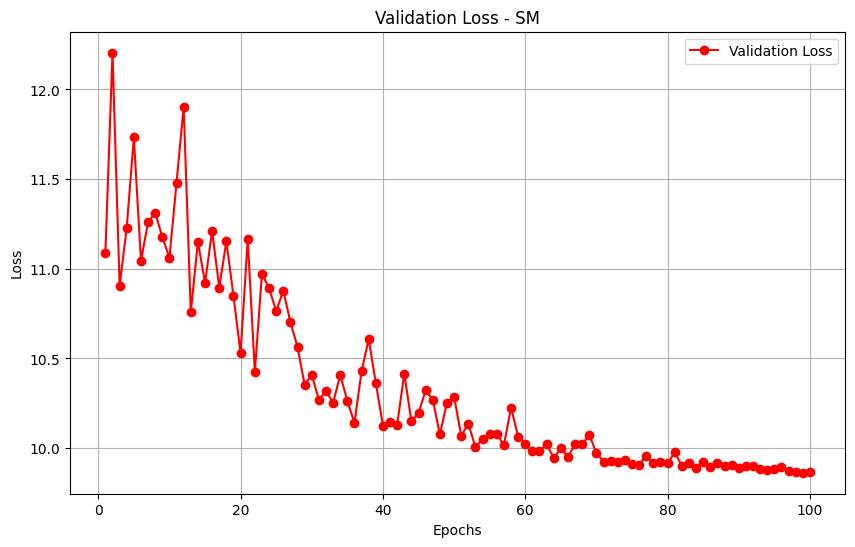

In [31]:
# Extract the loss values
train_loss = sm_metric_history['train']
val_loss = sm_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
epochs = list(range(1, 101))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### ET

In [22]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,1], target[:,:,1], squared=False)
    return metric_epoch


# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}

model, et_loss_history ,et_metric_history = train_val(model, params_train)

Epoch 0/99, current lr=0.01
Copied best model weights!
train loss: 83.64627074101323, train metric: 1.1774626970291138
val loss: 84.61734121394437, val metric: 0.9901079535484314
----------
Epoch 1/99, current lr=0.01
Copied best model weights!
train loss: 77.26389386850104, train metric: 1.081068754196167
val loss: 73.4239342917055, val metric: 0.9847779870033264
----------
Epoch 2/99, current lr=0.01
train loss: 78.60898875952361, train metric: 1.1787779331207275
val loss: 83.27236907662254, val metric: 0.9931680560112
----------
Epoch 3/99, current lr=0.01
train loss: 82.70700341983328, train metric: 1.143151044845581
val loss: 75.3615402453738, val metric: 1.2739800214767456
----------
Epoch 4/99, current lr=0.01
Copied best model weights!
train loss: 82.52325465280813, train metric: 1.0891969203948975
val loss: 72.21157312690394, val metric: 0.9942906498908997
----------
Epoch 5/99, current lr=0.01
train loss: 81.10185607092042, train metric: 1.0988026857376099
val loss: 72.579537

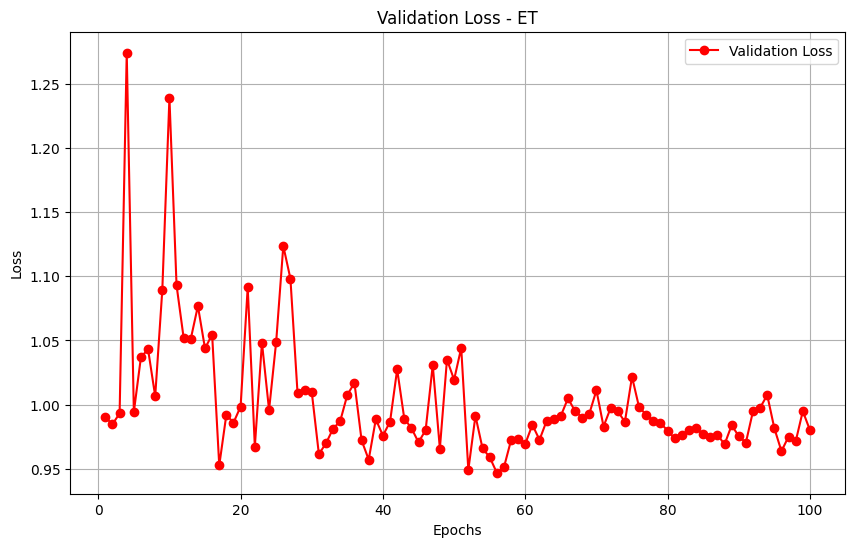

In [30]:
import matplotlib.pyplot as plt

# Extract the loss values
train_loss = et_metric_history['train']
val_loss = et_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
epochs = list(range(1, 101))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - ET')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()